# Parameterized Models 

We will create polynomial models for data tables so that we can produce values at any given input point.

In [86]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
#github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_styles = "./styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.079
molwtH2O = 18.015
densityH2SO4 = 1.83
densityH2O = 1.00


## Convertng Molal to %mass

The code below will convert molality to %mass and moles/L

In [87]:
##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "03_H2SO4_PercentWt_to_MolarConc_CRC.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Rename columns to make them easier to use
df = df.rename(columns={"%H2SO4": "PercentWt",
                        "m(mol/Kg)": "Molal",
                        "mol/L": "Molar",
                        "Density": "Density"})

display(df.head(3))

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["Molal"] * molwtH2SO4) / (df["Molal"] * molwtH2SO4 + 1000) * 100 

### Convert Molal to Molar
### Molar = Molal * densityH2SO4 / (1 + (molality * (molwtH2SO4 - molwtH2O) / 1000))                
volume = (df["Molal"] * molwtH2SO4 + 1000) / df["Density"] /1000
df["Molar_Calc"] = df["Molal"]/volume


### calculate difference between calculated and table values
df["PercentWt_Diff"] = (df["PercentWt_Calc"] - df["PercentWt"])/df["PercentWt"] * 100
df["Molar_Diff"] = (df["Molar_Calc"] - df["Molar"])/df["Molar"] * 100

display(df)


,PercentWt,Molal,Molar,Density
0,0.0,0.000,0.000,0.99821
1,0.5,0.051,0.051,1.00160
2,1.0,0.103,0.102,1.00490


,PercentWt,Molal,Molar,Density,PercentWt_Calc,Molar_Calc,PercentWt_Diff,Molar_Diff
0,0.0,0.000,0.000,0.99821,0.000000,0.000000,NaN,NaN
1,0.5,0.051,0.051,1.00160,0.497713,0.050827,-0.457335,-0.338510
2,1.0,0.103,0.102,1.00490,1.000110,0.102470,0.011045,0.460332
3,2.0,0.208,0.206,1.01160,1.999257,0.206206,-0.037126,0.100052
4,3.0,0.315,0.311,1.01830,2.996900,0.311152,-0.103346,0.048717
...,...,...,...,...,...,...,...,...
57,92.0,117.251,17.109,1.82400,91.999911,17.109456,-0.000097,0.002668
58,94.0,159.734,17.550,1.83120,93.999958,17.550416,-0.000044,0.002370
59,96.0,244.698,17.966,1.83550,95.999958,17.965917,-0.000044,-0.000459
60,98.0,499.592,18.346,1.83610,97.999979,18.346207,-0.000021,0.001127


Differential between reported molarity and value calculated from reported molality and density
Using density from CRC table at 20C


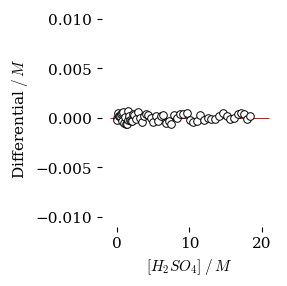

In [88]:
#x = df["PercentWt"]
x = df["Molar"]
y_w_diff = df["PercentWt_Calc"]-df["PercentWt"]
y_M_diff = df["Molar_Calc"]-df["Molar"]

#y = y_w_diff
#y = df["PercentWt_Diff"]
#y = df["Molar_Diff"]
y = y_M_diff

###################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$[H_2SO_4]\;/\,M$" 
y_label = r"Differential$\;/\,M$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
#        xlim=[-0.011,0.011],
        ylim=[-0.011,0.011]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
#ax.scatter(x, y,           # White circle behind each data point 
#          marker = "o", s = 90, 
#          color = "white", 
#          zorder = 1)
ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)
ax.hlines(0, -1,21, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
#ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
#        )
# 1:1 line
print("Differential between reported molarity and value calculated from reported molality and density")
print("Using density from CRC table at 20C")
plt.savefig("plots/plot_A1.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################




## At 25degC

The data above from the CRC handobbok was a data tabkle for 20degC.  There is a second table availabe in the web edition of the hanbook that gives the data at several different tempertures including 20 and 25 degC. The data below is from "Perry's Chemical Engineers' Handbook" 7th ed., section 2-107. It is the same data table as in the CRC but reports data at every degree rather than every second degree. It is just the output of a parameterized model that I have no information about.

### Refs

A very recent paper that is much too complicated

Genetic Algorithm Workflow for Parameterization of a Water Model Using the Vashishta Force Field
Anthony Val C. Camposano, Even Marius Nordhagen, Henrik Andersen Sveinsson, and Anders Malthe-So̷renssen
The Journal of Physical Chemistry B 2025 129 (4), 1331-1342
DOI: 10.1021/acs.jpcb.4c06389

A polynomial model for pure water density (and also salt water)

Baddour, R. E. (2023). Thermohaline equation of state for pure water, seawater and brine. Journal of Hydraulic Research, 61(2), 211–219. https://doi.org/10.1080/00221686.2023.2180444

densitywater(Temp degC)(kg/m^3) = (9.99864928×10^2) + (5.72357369×10^−2)⁢ T + (−7.96007024×10^−3⁢)T^2 + (5.32777547×10^−5)⁢T^3 + (−2.60322680×10^−7⁢)T^4 + (5.11178237×10−10)⁢T^5

Polynomial fits for sulfuric acid mixtures at given temp. Up to 40%H2SO4 only

Review and Analysis of Thermophysical Properties of a Sulfuric Acid–Water Electrolyte
Laura Oca, Jose Miguel Campillo-Robles, and M. Mounir Bou-Ali
Journal of Chemical & Engineering Data 2018 63 (9), 3572-3583
DOI: 10.1021/acs.jced.8b00466
GET ref 40, 41, 47,48,49 etc...

Data Set from 

Tables of physical and chemical constants and some mathematical functions / originally compiled by G.W.C. Kaye and T.H. Laby ; now prepared under the direction of an editorial committee.
London ; New York : Longman, 1986. 15th ed.
Reference section of library	QC61.K3 1986 REF

A four parameter fit
Surface Tensions and Densities of Sulfuric Acid + Dimethylamine + Water Solutions
Antti-P. Hyvärinen, Heikki Lihavainen, Kaisa Hautio, Tomi Raatikainen, Yrjö Viisanen, and Ari Laaksonen
Journal of Chemical & Engineering Data 2004 49 (4), 917-922
DOI: 10.1021/je034225b

Crazy Fits
Densities and Apparent Molar Volumes of Atmospherically Important Electrolyte Solutions. 1. The Solutes H2SO4, HNO3, HCl, Na2SO4, NaNO3, NaCl, (NH4)2SO4, NH4NO3, and NH4Cl from 0 to 50 °C, Including Extrapolations to Very Low Temperature and to the Pure Liquid State, and NaHSO4, NaOH, and NH3 at 25 °C
S. L. Clegg and A. S. Wexler
The Journal of Physical Chemistry A 2011 115 (15), 3393-3460
DOI: 10.1021/jp108992a
see refs 2, 184, 117, 109

In [89]:
Data_File_Name = "03_H2SO4_PercentWt_to_Density_Temp_CRC.csv"

Filename = github_location + Data_File_Name

df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col=False, 
                 comment = "#") 

### Rename columns to make them easier to use
df2 = df2.rename(columns={"%H2SO4": "PercentWt",
                        })

display(df2.head(3))

display(df.head(3))

### Convert Molal to PercentWt
### PercentWt = (molality * molwtH2SO4) / (molality * molwtH2SO4 + 1000) * 100
df["PercentWt_Calc"] = (df["Molal"] * molwtH2SO4) / (df["Molal"] * molwtH2SO4 + 1000) * 100 

### Convert Molal to Molar
### Molar = Molal * densityH2SO4 / (1 + (molality * (molwtH2SO4 - molwtH2O) / 1000))      
#density = df2["20C"]          
#density = df["Density"]          
density = np.interp(df["PercentWt"], df2["PercentWt"], df2["20C"])

volume = (df["Molal"] * molwtH2SO4 + 1000) / density /1000
df["Molar_Calc"] = df["Molal"]/volume

### calculate difference between calculated and table values
df["PercentWt_Diff"] = (df["PercentWt_Calc"] - df["PercentWt"])/df["PercentWt"] * 100
df["Molar_Diff"] = (df["Molar_Calc"] - df["Molar"])/df["Molar"] * 100

display(df)


,PercentWt,0C,10C,15C,20C,25C,30C,40C,50C,60C,80C,100C
0,0,NaN,0.9997,0.9991,0.99821,0.99705,0.99565,0.99222,0.98804,0.9832,0.97179,NaN
1,1,1.0074,1.0068,1.0060,1.00510,1.00380,1.00220,0.99860,0.99440,0.9895,0.97790,0.9645
2,2,1.0147,1.0138,1.0129,1.01180,1.01040,1.00870,1.00500,1.00060,0.9956,0.98390,0.9705


,PercentWt,Molal,Molar,Density,PercentWt_Calc,Molar_Calc,PercentWt_Diff,Molar_Diff
0,0.0,0.000,0.000,0.99821,0.000000,0.000000,NaN,NaN
1,0.5,0.051,0.051,1.00160,0.497713,0.050827,-0.457335,-0.338510
2,1.0,0.103,0.102,1.00490,1.000110,0.102470,0.011045,0.460332


,PercentWt,Molal,Molar,Density,PercentWt_Calc,Molar_Calc,PercentWt_Diff,Molar_Diff
0,0.0,0.000,0.000,0.99821,0.000000,0.000000,NaN,NaN
1,0.5,0.051,0.051,1.00160,0.497713,0.050830,-0.457335,-0.333037
2,1.0,0.103,0.102,1.00490,1.000110,0.102490,0.011045,0.480326
3,2.0,0.208,0.206,1.01160,1.999257,0.206247,-0.037126,0.119842
4,3.0,0.315,0.311,1.01830,2.996900,0.311182,-0.103346,0.058542
...,...,...,...,...,...,...,...,...
57,92.0,117.251,17.109,1.82400,91.999911,17.109456,-0.000097,0.002668
58,94.0,159.734,17.550,1.83120,93.999958,17.550416,-0.000044,0.002370
59,96.0,244.698,17.966,1.83550,95.999958,17.965917,-0.000044,-0.000459
60,98.0,499.592,18.346,1.83610,97.999979,18.346207,-0.000021,0.001127


## 

Differential between reported molarity and value calculated from reported molality and density
Using density interpolated from Perry table at 20C


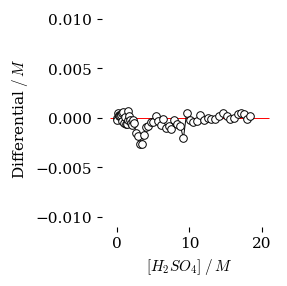

In [90]:
x = df["PercentWt"]
x = df["Molar"]

y_w_diff = df["PercentWt_Calc"]-df["PercentWt"]
y_M_diff = df["Molar_Calc"]-df["Molar"]

y = y_w_diff
#y = df["PercentWt_Diff"]
y = df["Molar_Diff"]
y = y_M_diff
####################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$[H_2SO_4]\;/\,M$" 
y_label = r"Differential$\;/\,M$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
#        xlim=[-2,50],
        ylim=[-0.011,0.011]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
#ax.scatter(x, y,           # White circle behind each data point 
#          marker = "o", s = 90, 
#          color = "white", 
#          zorder = 1)
ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)
ax.hlines(0, -1,21, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
#ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
#        )
# 1:1 line
print("Differential between reported molarity and value calculated from reported molality and density")
print("Using density interpolated from Perry table at 20C")
plt.savefig("plots/plot_A2.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################




Differential between reported %H2SO4 and value calculated from reported molality


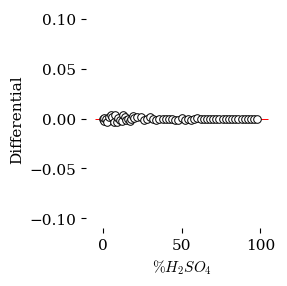

In [91]:
x = df["PercentWt"]
y_w_diff = df["PercentWt_Calc"]-df["PercentWt"]
y_M_diff = df["Molar_Calc"]-df["Molar"]

y = y_w_diff
#y = df["PercentWt_Diff"]
#y = df["Molar_Diff"]
####################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$" 
y_label = r"Differential" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
#        xlim=[-2,50],
        ylim=[-0.11,0.11]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
#ax.scatter(x, y,           # White circle behind each data point 
#          marker = "o", s = 90, 
#          color = "white", 
#          zorder = 1)
ax.plot(x, y,  
          color = "black", linewidth=0.7, 
          zorder = 1)
ax.hlines(0, -5,105, color="red", linewidth=0.7, zorder = 0)   # horizontal line at y=0
#ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
#        )
# 1:1 line
print("Differential between reported %H2SO4 and value calculated from reported molality")
plt.savefig("plots/plot_A3.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################


